<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: 3.0 Model selection

> Authors: Pius Yee, Conrad Aw, Eugene Matthew Cheong
---

## Table of Contents ##

### [1.0 Data Collection](./1.0%20Web%20Scraping.ipynb) ###

[1.1 Import Packages](./1.0%20Web%20Scraping.ipynb)

[1.2 Webscraping](./1.0%20Web%20Scraping.ipynb)

[1.3 Selection of subreddits](./1.0%20Web%20Scraping.ipynb)

[1.4 Code for text scraping](./1.0%20Web%20Scraping.ipynb)

### [2.0 Data Cleaning, Preprocessing and EDA](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.1 Import CSV file](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.2 Data cleaning](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.3 Preprocessing](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.4 Exploratory Data Analysis (EDA)](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

### 3. Modelling, Evaluation and Tuning

[3.1 Import CSV file](#3.1-Import-CSV-file)

[3.2 Splitting of train/test data](#3.2-Splitting-of-train/test-data)

[3.3 Modelling](#3.3-Modelling)

[3.4 Model Selection](#3.4-Model-Selection)

[3.5 AUC-ROC](#3.5-AUC-ROC)

[3.6 Save it as Pickle](#3.6-Save-it-as-Pickle)

[3.7 Recommendations](#3.7-Recommendations)

[3.8 Conclusion](#3.8-Conclusion)

### [4. Model Testing](./4.0%20Model%20Test.ipynb)

[4.1 Scraping Input Reddit](./4.0%20Model%20Test.ipynb)

[4.2 Cleaning Data](./4.0%20Model%20Test.ipynb)

[4.3 Tokenizing with Regex](./4.0%20Model%20Test.ipynb)

[4.4 Stop Word Removal](./4.0%20Model%20Test.ipynb)

[4.5 Lemmatization](./4.0%20Model%20Test.ipynb)

[4.6 Run the model](./4.0%20Model%20Test.ipynb)

---

##### In this notebook, we will proceed with model tuning and selection based on the cleaned dataset from the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_colwidth', 100)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression



---
### 3.1 Import CSV file

In [2]:
# read the cleaned dataset from previous notebook

final_df = pd.read_csv('../datasets/final_df.csv')

In [3]:
final_df.head()

,Unnamed: 0,category,text,mum
0,0,title,"['dad', 'tip']",0
1,1,selftext,"['found', 'couple', 'week', 'ago', 'friend', 'pregnant', 'first', 'wrote', 'help', 'prepare', 'f...",0
2,3,comment,"['think', 'people', 'look', 'risk', 'decide', 'whats', 'best', 'based', 'situation', 'bedsharing...",0
3,5,comment,"['one', 'hate', 'air', 'conditioning', 'house', 'made', 'proper', 'material', 'making', 'ductwor...",0
4,6,comment,"['dont', 'cosleep', 'aside', 'sids', 'there', 'also', 'chance', 'crushing', 'kid']",0


---
### 3.2 Splitting of train/test data

### Based on the cleaned dataset, we will train a model to predict whether a text post belongs to 'mum' (1) or not (0). 

### We will split the dataset into 'train' and 'test' sets for model training purposes.

In [4]:
# assign X and y

X = final_df.text
y = final_df.mum

In [5]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y, # we used stratify since our dataset is imbalanced
                                                    random_state=42)

---
### 3.3 Modelling

### **Model**

##### We will tune two models and select the model with the best score as our final model.

##### (1) Naive Bayes (Multinomial)

##### (2) Logistics Regression

### **Approaches**

##### We will tune the model using GridSearchCV with our pipeline. This means we will tune hyperparameters associated with specific steps within the pipeline. 

##### To optimize model performance, we will use GridSearch to tune the hyperparameters of all of our models and vectorizers. Then we will compare the resulting optimized models and choose the best out of them.

##### To simplify this  process, we've created a function to generate a dictionary containing the results from Gridsearch.

### **Metrics**

##### For model metrics, we will use **F1 score** as our main metrics to assess the model.

##### The main reason for using F1 score as the main metric is to find a good balance between precision and sensitivity. Both the metrics are important for our model because it will use the classifier to identify "mum" comments from the datasets. Precision helps to maximize the true positive out of all the model predicted as positive, and sensitivity is for true positives out of all positive posts in the datasets.

##### (1) F1 Score: Harmonic mean of precision and sensitivity, combining both metrics into a single score that penalizes models with uneven class distribution. **Primary metrics

##### (2) Precision: Measures the proportion of positive predictions that were actually correct (positive predictive value).

##### (3) Sensitivity (Recall): The proportion of actual positive cases that the model correctly identified (true positives out of all positive examples).**

##### (4) Specificity: Measures the proportion of negative predictions that were actually correct (true negative rate).

##### (5) Accuracy: Overall proportion of correct predictions (both positive and negative).




---
### **Baseline**

##### We always begin by creating a baseline model to provide a comparison point for our subsequent models. In this case, we can use the normalized value of 'y'. This represents the simplest possible model – randomly assigning posts would still give us a 39% chance of classifying them correctly.

In [6]:
# baseline model
y.value_counts(normalize = True)

mum
0    0.611611
1    0.388389
Name: proportion, dtype: float64

---

## Model 1 - Multinomial Naive Bayes

##### The model will be trained using CountVectorizer and TF-IDF. The following parameters in the pipeline will be considered:

(1) **Max features**: Controls the maximum number of features (words/terms) considered from the vocabulary when creating the vectorized representation of the text.

(2) **Min_df**: Sets a threshold for the minimum document frequency of a term – terms appearing in fewer documents than this threshold will be ignored.

(3) **Max_df**: Sets a threshold for the maximum document frequency of a term – terms appearing in more documents than this threshold will be ignored.

(4) **N-gram range**: Determines the range of n-grams to be extracted as features (e.g., an ngram_range of (1,2) will extract both single words and consecutive two-word phrases).

In [7]:
# create a function to generate a dictionary of scores based on the model tuning parameters.

def grid_nb(vector):

    # instantiate vectorizer based on the given argument
    if vector == "cvec": # for countVector
        pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('nb', MultinomialNB())
        ])
    elif vector == "tvec": # for TF-IDF
         pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('nb', MultinomialNB())
        ])       
         
    # set the pipeline
    pipe_params = {
    vector+'__max_features': [7000,8000,9000], # range 7000 to 9000 is the best for max features based on our experiment
    vector+'__min_df': [1, 2], # lower minimum threshold for frequency is better
    vector+'__max_df': [.1, .2, .3], # range 0.1 to 0.3 is the best
    vector+'__ngram_range': [(1,1), (1,2), (1,3)] 
    }

    # set the gridsearch
    gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, # parameter values
                  n_jobs=-1,
                  verbose = 1,
                  scoring= "f1",
                  cv=5) # 5-fold cross-validation.

    # fit the gridsearch on train data
    gs.fit(X_train, y_train)

    # set up the metrics
    y_pred = gs.predict(X_test) # get prediction
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
    precision = tp /(tp+fp)
    sensitivity = tp / (tp+fn)


    # creata a dictionary for the score
    result_dict = {
        "Model": "Naive Bayes - Multinomial",
        "Vectorizer": ("CountVectorizer" if vector == "cvec" else "TfidfVectorizer"),
        "Best parameter": gs.best_params_,
        "Average F1 score with 5 folds": gs.best_score_ ,
        "F1 score on train": gs.score(X_train, y_train),
        "F1 score on test": gs.score(X_test, y_test),
        "Sensitivity": sensitivity,
        "Precision": (precision),
        "Specificity": tn / (tn+fp),
        "Accuracy": ((tp+tn)/(tp+tn+fp+fn))
        
        }

    return result_dict # return the dictionary

##### Run the function to generate the scores based on the vectorization
(1) cvec: CountVectorizor
(2) tvec: TF-IDF vectorizor

In [8]:
naive_cvec_dict = grid_nb("cvec") # Call the function for "CountVectorizor"
naive_tvec_dict = grid_nb("tvec") # Call the function for "TF-IDF" vectorizor

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Fitting 5 folds for each of 54 candidates, totalling 270 fits


##### For better readability, we put both dictionary from "CountVectorizor" and "TF_IDF" in a dataframe

In [9]:
pd.DataFrame([naive_cvec_dict,naive_tvec_dict])

,Model,Vectorizer,Best parameter,Average F1 score with 5 folds,F1 score on train,F1 score on test,Sensitivity,Precision,Specificity,Accuracy
0,Naive Bayes - Multinomial,CountVectorizer,"{'cvec__max_df': 0.3, 'cvec__max_features': 9000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}",0.720852,0.76459,0.731145,0.708710,0.755047,0.854013,0.797584
1,Naive Bayes - Multinomial,TfidfVectorizer,"{'tvec__max_df': 0.2, 'tvec__max_features': 9000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}",0.629599,0.70049,0.640493,0.514423,0.848414,0.941641,0.775728


---

## Model 2 - Logistics Regression

##### Similar to Model 1 - Naive Bayes, the model 2 (Logistic Regression) will be trained using CountVectorizer and TF-IDF. The following additional parameters in the pipeline will be considered:

(1) **Penalty**: Controls the amount of regularization applied to the model to prevent overfitting. Common options are 'l1' (L1 regularization) for sparse models and 'l2' (L2 regularization) to reduce model complexity.

(2) **Solver**: The optimization algorithm used to find the coefficients that minimize the loss function. In our case, we only used the common choices 'liblinear' which usually for smaller datasets.

(3) **C**: Inverse of the regularization strength; a larger C value means less regularization. This parameter influences the trade-off between fitting the training data and avoiding overfitting.


In [10]:
def grid_lr(vector):

    # instantiate vectorizer based on the given argument
    if vector == "cvec": # for countVector
        pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression())
        ])
    elif vector == "tvec": # for TF-IDF
         pipe = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('lr', LogisticRegression())
        ])       
         
    # set the pipeline
    pipe_params = {
    vector+'__max_features': [9000,10000,11000],
    vector+'__min_df': [2, 3],
    vector+'__max_df': [.2, .3, .4],
    vector+'__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__penalty': ['l1','l2'], #L1 is lasso and L2 is Ridge
    'lr__solver':['liblinear'],
    'lr__C': [0.1, 0.2,1],
    }

    # set the gridsearch
    gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, # parameters values
                  n_jobs=-1,
                  verbose = 1,
                  scoring= "f1",
                  cv=5) # 5-fold cross-validation.

    # fit the gridsearch on train data
    gs.fit(X_train, y_train)

    # set up the metrics
    y_pred = gs.predict(X_test) # get prediction
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
    precision = tp /(tp+fp)
    sensitivity = tp / (tp+fn)


    # creata a dictionary for the score
    result_dict = {
        "Model": "Logistics Regression",
        "Vectorizer": ("CountVectorizer" if vector == "cvec" else "TfidfVectorizer"),
        "Best parameter": gs.best_params_,
        "Average F1 score with 5 folds": gs.best_score_ ,
        "F1 score on train": gs.score(X_train, y_train),
        "F1 score on test": gs.score(X_test, y_test),
        "Sensitivity": sensitivity,
        "Precision": precision,
        "Specificity": tn / (tn+fp),
        "Accuracy": ((tp+tn)/(tp+tn+fp+fn))
        
        }

    return result_dict

##### Run the function to generate the scores based on the vectorization
(1) cvec: CountVectorizor
(2) tvec: TF-IDF vectorizor

In [11]:
logistics_cvec_dict = grid_lr("cvec")
logistics_tvec_dict = grid_lr("tvec")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


##### For better readability, we put both dictionary from "CountVectorizor" and "TF_IDF" in a dataframe

In [12]:
pd.DataFrame([logistics_cvec_dict,logistics_tvec_dict])

,Model,Vectorizer,Best parameter,Average F1 score with 5 folds,F1 score on train,F1 score on test,Sensitivity,Precision,Specificity,Accuracy
0,Logistics Regression,CountVectorizer,"{'cvec__max_df': 0.3, 'cvec__max_features': 11000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1...",0.710769,0.844581,0.710260,0.655826,0.774549,0.878793,0.792202
1,Logistics Regression,TfidfVectorizer,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tvec__max_df': 0.3, 'tvec__max_fea...",0.710110,0.780063,0.715776,0.649887,0.796534,0.894595,0.799561


---
### 3.4 Model Selection

##### Combined both model scores (Naive Bayes and Logistics Regression) into a dataframe for easy comparison

In [13]:
final_result_df = pd.DataFrame([naive_cvec_dict,naive_tvec_dict,logistics_cvec_dict,logistics_tvec_dict])
final_result_df

,Model,Vectorizer,Best parameter,Average F1 score with 5 folds,F1 score on train,F1 score on test,Sensitivity,Precision,Specificity,Accuracy
0,Naive Bayes - Multinomial,CountVectorizer,"{'cvec__max_df': 0.3, 'cvec__max_features': 9000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}",0.720852,0.764590,0.731145,0.708710,0.755047,0.854013,0.797584
1,Naive Bayes - Multinomial,TfidfVectorizer,"{'tvec__max_df': 0.2, 'tvec__max_features': 9000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}",0.629599,0.700490,0.640493,0.514423,0.848414,0.941641,0.775728
2,Logistics Regression,CountVectorizer,"{'cvec__max_df': 0.3, 'cvec__max_features': 11000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1...",0.710769,0.844581,0.710260,0.655826,0.774549,0.878793,0.792202
3,Logistics Regression,TfidfVectorizer,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tvec__max_df': 0.3, 'tvec__max_fea...",0.710110,0.780063,0.715776,0.649887,0.796534,0.894595,0.799561


##### Naive Bayes (multinomial) with CountVectorizer has the best score with the highest **F1 score** of 0.720852 (average F1 score with 5 folds), which is the primary metric for our case.
##### The details as below:-

In [14]:
print(final_result_df.iloc[0])

Model                                                                                                    Naive Bayes - Multinomial
Vectorizer                                                                                                         CountVectorizer
Best parameter                   {'cvec__max_df': 0.3, 'cvec__max_features': 9000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Average F1 score with 5 folds                                                                                             0.720852
F1 score on train                                                                                                          0.76459
F1 score on test                                                                                                          0.731145
Sensitivity                                                                                                                0.70871
Precision                                                                          

#### Re-run the final model

##### Now we have identified Naive Bayes (multinomial) with CountVectorizor as our final model. We will re-run the model to save it as pickle and use it for Streamlit.

In [15]:
# Set params based on the best model identified above

cvec_params ={
 'max_df': 0.3,
 'max_features': 9000,
 'min_df': 2,
 'ngram_range': (1, 1)}

In [16]:
# Set pipeline to include the vectorizor and model

pipeline = Pipeline([
    ('tvec', CountVectorizer(**cvec_params)),
    ('nb', MultinomialNB())
])

In [17]:
# Fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 CountVectorizer(max_df=0.3, max_features=9000, min_df=2)),
                ('nb', MultinomialNB())])

In [18]:
# Get prediction for X test
y_pred = pipeline.predict(X_test)

##### Now we have fitted the best model to "pipeline".

##### The confusion matrix as below:-

In [19]:
# Build the confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
precision = tp /(tp+fp)
sensitivity = tp / (tp+fn)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) # F1 Score = 2 * (precision * recall) / (precision + recall)

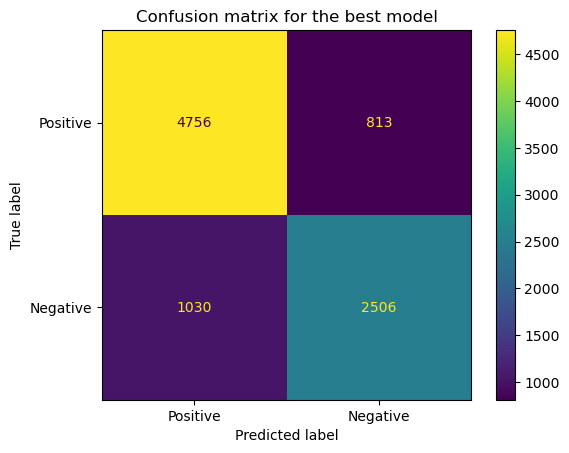

{'True Positive': 2506, 'True Negative': 4756, 'False Positive': 813, 'False Negative': 1030}


In [20]:
# plot the confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=['Positive', 'Negative'])
disp.plot(include_values=True);
plt.title("Confusion matrix for the best model")
plt.show()
print({'True Positive':tp, "True Negative": tn, "False Positive":fp, "False Negative": fn})

##### Based on the confusion matrix above, we have strong true positive (4756) and true negative (2506). It indicates that we are able to predict majority of correct "mum" and "non-mum" comments accurately.

---
#### 3.5 AUC-ROC

##### AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a single score summarizing how well a classification model distinguishes between positive and negative classes. It considers performance across all classification thresholds, making it robust for imbalanced data. A perfect model has an AUC of 1, while a random guess scores 0.5. 

##### The higher the AUC, the better the model can differentiate positive from negative cases.

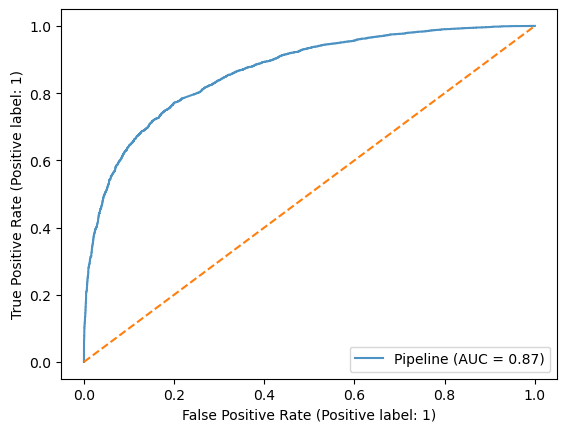

In [21]:
# Calculate ROC metrics
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba) #fpr is false positive rate, tpr is true positive rate
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve using RocCurveDisplay
roc_viz = RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=None, alpha=0.8)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') # plot the baseline
plt.show()

##### Based on the chart above, our AUC is 0.87 which is considered very good as it close to 1. It means both population "mum" and " dad" can be separated well. 

---
##### Overall scores for the best model - Multinomial Naive Bayes with CountVectorizer

In [22]:
# Scores for the best model

{"F1 score": f1_score, "Precision": precision, "Sensitivity (Recall)": sensitivity, "Specificity": tn / (tn+fp),"Accuracy": ((tp+tn)/(tp+tn+fp+fn)),}

{'F1 score': 0.7311451495258934,
 'Precision': 0.755046700813498,
 'Sensitivity (Recall)': 0.708710407239819,
 'Specificity': 0.8540132878434189,
 'Accuracy': 0.7975837451949478}

##### Based on the scores above, we can conclude that:-

##### (1) F1 Score: 0.731 is a best balance of precision and sensitivity based on our model tuning.

##### (2) Precision: 0.755 could means that out of 100 comments predicted as "mum", 75.5 comments are predicted correctly as mum

##### (3) Sensitivity (Recall): 0.708 means that out of 100 comments from mum in the data, 70.8 comments are correctly capture as "mum" by our model.

##### (4) Specificity: 0.854 means that out of 100 comments from dad in the data, 85.4 comments are correctly capture  as "dad" by our model.

##### (5) Accuracy: 0.798 means that out of 100 comments in the data, our model correctly classifies 79.8 comments as either true positive or true negative.

---
### 3.6 Save it as Pickle

In [23]:
# save it as Pickle for streamlit purpose
    
import pickle

#To write out the pickle file
with open('../datasets/final_model.pkl', 'wb') as handle:
    pickle.dump(pipeline, handle)

---
#### Limitation

##### - Unable to identify localized words
The model was trained on data from the global subreddits r/daddit and r/Mummit.

##### - Performance of the model is constrained by limitations in the Naive Bayes and Logistics Regression approach.
Exhaustive tuning did not yield substantial improvements.

---
### 3.7 Recommendations

##### - **With more resources:**
We can acquire more localized data from either from other social media platforms or forums.
For example: Picking up Singlish.

##### - **Use more complex models such as Random Forest or XGBoost.**
To have more accurate classification

---
### 3.8 Conclusion

##### Our model (Multinomial Naive Bayes with CountVectorizer) demonstrates strong performance in classifying posts from subreddits to identify whether they were written by a mum or dad. However, there's room for further improvement using the following ideas: 

- We can acquire more localized data from either from other social media platforms or forums.

- Use more complex models such as Random Forest or XGBoost to have more accurate classification.

#### Next Notebook: [4.0 Model Test](./4.0%20Model%20Test.ipynb)